# 신용카드 사용자 연체 예측 분석

- gender: 성별
- car: 차량 소유 여부
- reality: 부동산 소유 여부
- child_num: 자녀 수
- income_total: 연간 소득
- income_type: 소득 분류
['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']

- edu_type: 교육 수준 ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']

- family_type: 결혼 여부['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']

- house_type: 생활 방식
 ['Municipal apartment', 'House / apartment', 'With parents', Co-op apartment', 'Rented apartment', 'Office apartment']

- DAYS_BIRTH: 출생일(데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미)

- DAYS_EMPLOYED: 업무 시작일(데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미), 양수 값은 고용되지 않은 상태를 의미함

- FLAG_MOBIL: 핸드폰 소유 여부
- work_phone: 업무용 전화 소유 여부
- phone: 전화 소유 여부
- email: 이메일 소유 여부
- occyp_type: 직업 유형
- family_size: 가족 규모
- begin_month: 신용카드 발급 월(데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미)

- credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도 => 낮을 수록 높은 신용의 신용카드 사용자를 의미함

#### Logloss
- Logloss 값은 분류모델에서 평가지표로 사용하는 지표 중 하나이며, 0에 가까울수록 정확하다는 뜻이고, 확률이 낮아질수록 logloss값은 급격하게 커진다

In [2]:
!pip install pycaret
!pip install category_encoders

  Using cached pywin32-227-cp38-cp38-win_amd64.whl (9.1 MB)
  Attempting uninstall: pywin32
    Found existing installation: pywin32 302


ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\user\\.conda\\envs\\qtqt\\Lib\\site-packages\\win32\\_win32sysloader.pyd'
Consider using the `--user` option or check the permissions.



    Uninstalling pywin32-302:
      Successfully uninstalled pywin32-302
  Rolling back uninstall of pywin32
  Moving to c:\users\user\.conda\envs\qtqt\lib\site-packages\__pycache__\pythoncom.cpython-38.pyc
   from C:\Users\user\AppData\Local\Temp\pip-uninstall-xa7x4piq\pythoncom.cpython-38.pyc
  Moving to c:\users\user\.conda\envs\qtqt\lib\site-packages\adodbapi
   from C:\Users\user\.conda\envs\qtqt\Lib\site-packages\~dodbapi
  Moving to c:\users\user\.conda\envs\qtqt\lib\site-packages\isapi
   from C:\Users\user\.conda\envs\qtqt\Lib\site-packages\~sapi
  Moving to c:\users\user\.conda\envs\qtqt\lib\site-packages\pythoncom.py
   from C:\Users\user\AppData\Local\Temp\pip-uninstall-2h9l6v6n\pythoncom.py
  Moving to c:\users\user\.conda\envs\qtqt\lib\site-packages\pythonwin
   from C:\Users\user\.conda\envs\qtqt\Lib\site-packages\~ythonwin
  Moving to c:\users\user\.conda\envs\qtqt\lib\site-packages\pywin32-302-py3.8.egg-info
   from C:\Users\user\.conda\envs\qtqt\Lib\site-packages\~ywi

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings, random
warnings.filterwarnings(action='ignore')

import scipy.stats as stats 

from IPython.display import set_matplotlib_formats

mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus =True)
set_matplotlib_formats('retina')
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [5]:
train=pd.read_csv('train3.csv')
test=pd.read_csv('test3.csv')

In [6]:
for df in [train,test]:
    print(df.shape)

(24474, 19)
(9513, 18)


## Feature Engineering

### 1등 feature

In [7]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'child_num'}>,
        <AxesSubplot:title={'center':'income_total'}>,
        <AxesSubplot:title={'center':'DAYS_BIRTH'}>,
        <AxesSubplot:title={'center':'DAYS_EMPLOYED'}>],
       [<AxesSubplot:title={'center':'work_phone'}>,
        <AxesSubplot:title={'center':'phone'}>,
        <AxesSubplot:title={'center':'email'}>,
        <AxesSubplot:title={'center':'family_size'}>,
        <AxesSubplot:title={'center':'begin_month'}>],
       [<AxesSubplot:title={'center':'credit'}>,
        <AxesSubplot:title={'center':'before_EMPLOYED'}>,
        <AxesSubplot:title={'center':'income_total_befofeEMP_ratio'}>,
        <AxesSubplot:title={'center':'before_EMPLOYED_m'}>,
        <AxesSubplot:title={'center':'before_EMPLOYED_w'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'DAYS_BIRTH_m'}>,
        <AxesSubplot:title={'center':'DAYS_BIRTH_w'}>,
        <AxesSubp

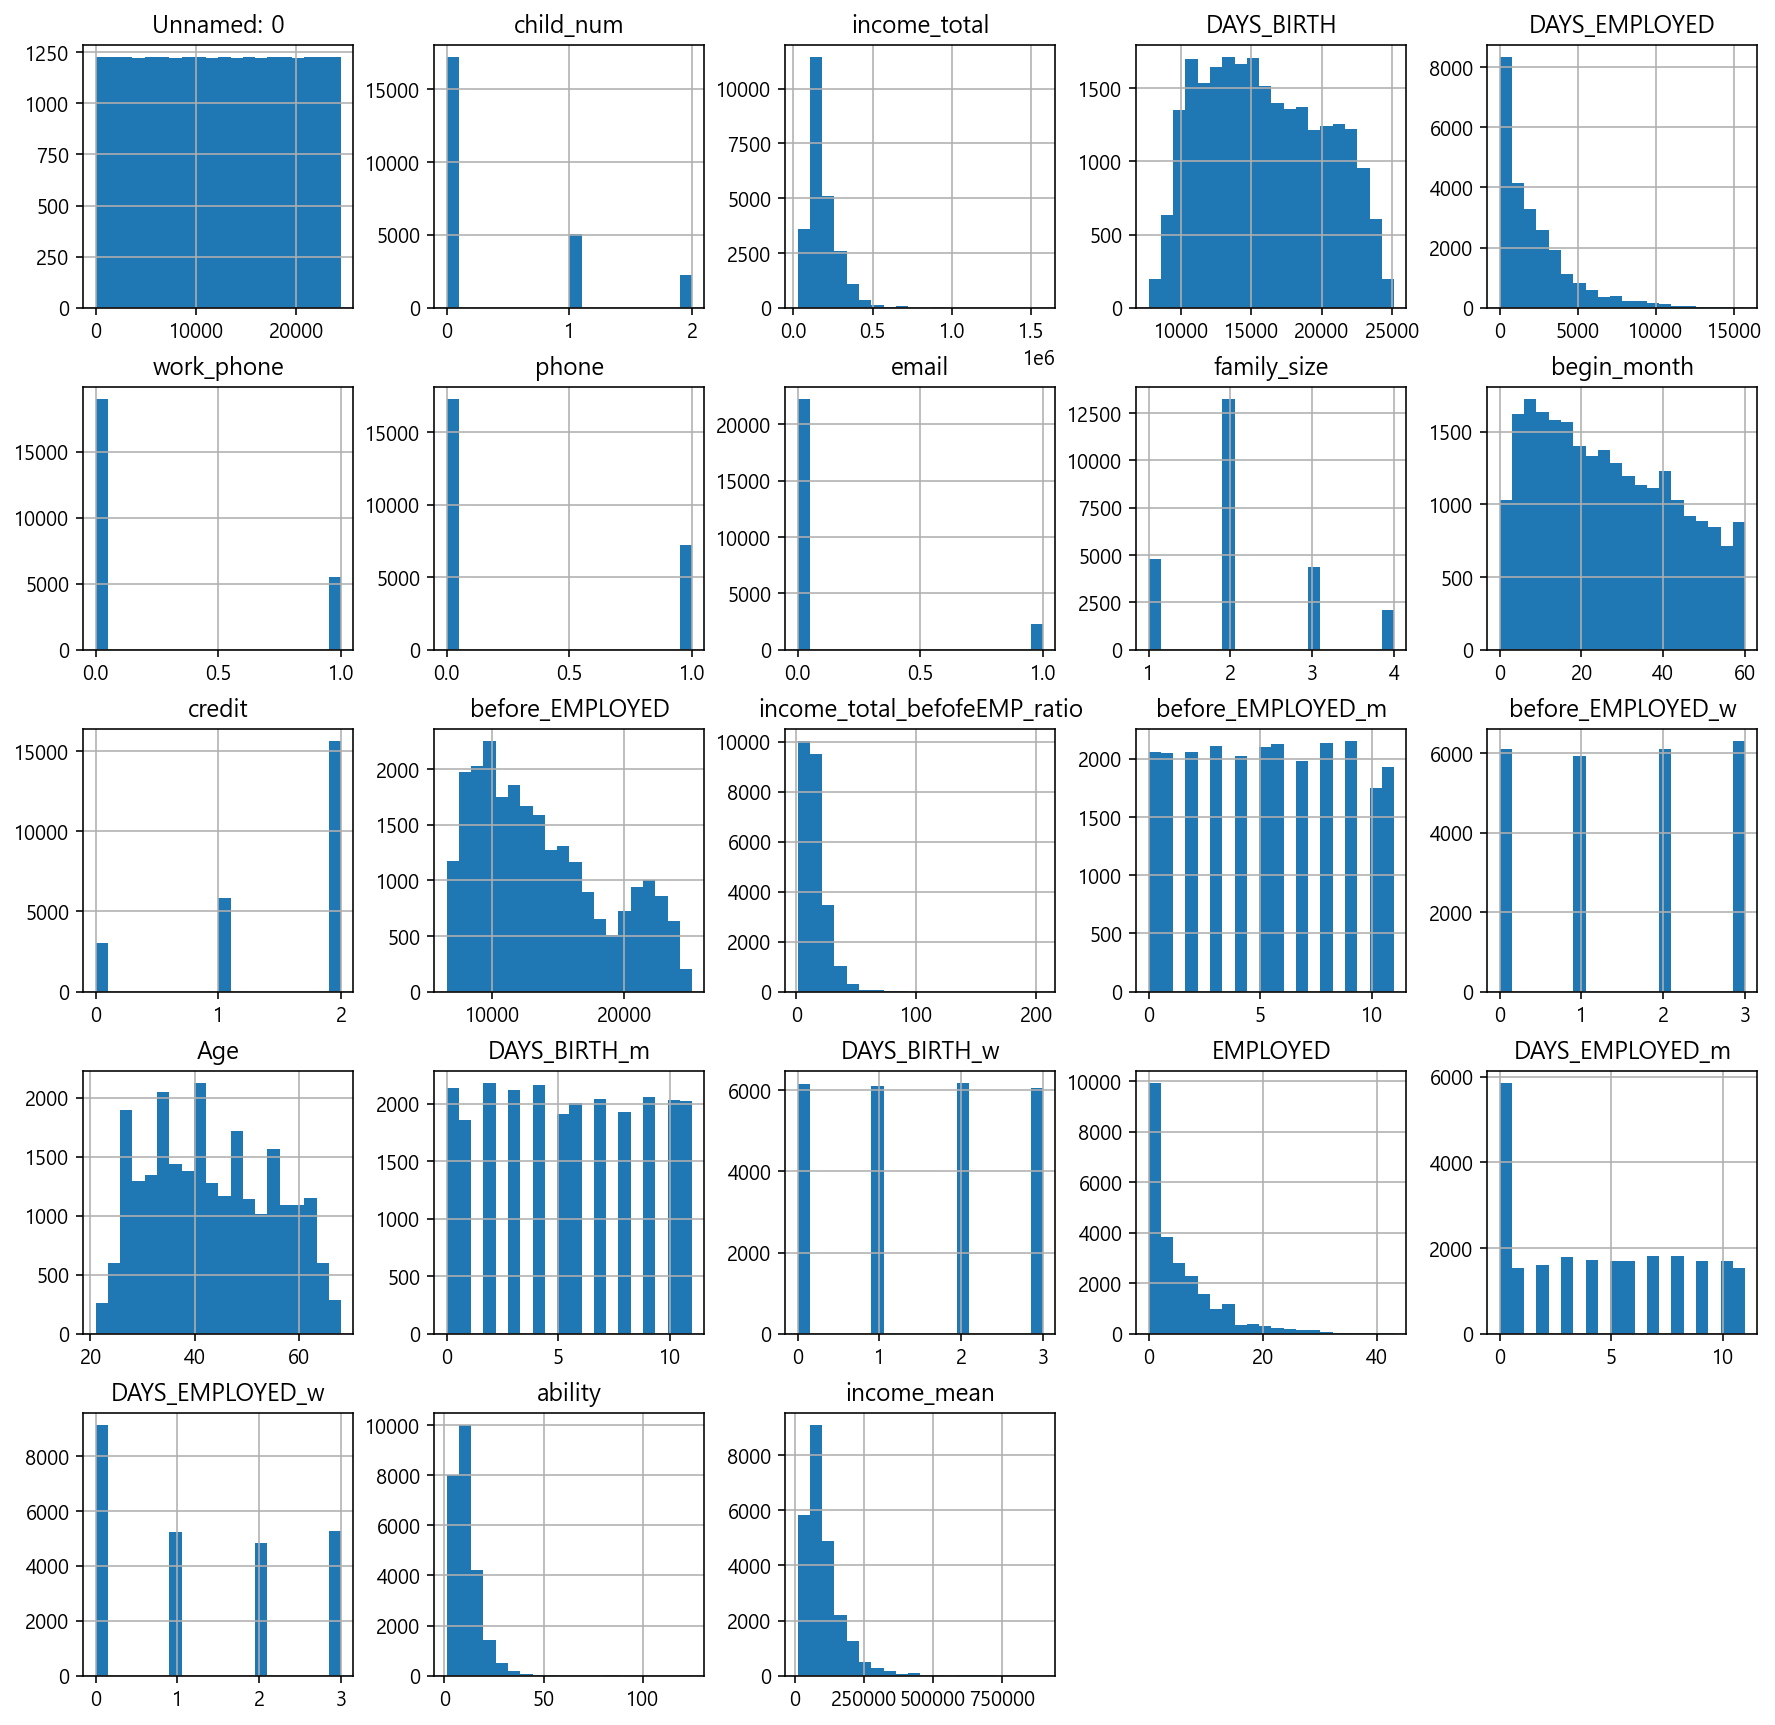

In [8]:
train.hist(figsize=(15,15),bins=20)

In [9]:
train.shape

(24474, 32)

In [10]:
for df in [train,test]:
    df.drop('Unnamed: 0',axis=1,inplace=True)

In [11]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,before_EMPLOYED,income_total_befofeEMP_ratio,before_EMPLOYED_m,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,0,0,0,freelancer,2.0,6.0,1.0,9190,22.034820,6.0,0.0,38,7.0,1.0,12,0.0,0.0,10.882416,101250.0,0_202500.0_13899_4709_0_0_0_2.0_F_N_N_Commerci...
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,0,0,1,Laborers,3.0,5.0,1.0,9840,25.152439,4.0,1.0,31,7.0,1.0,4,3.0,0.0,19.156347,82500.0,1_247500.0_11380_1540_0_0_1_3.0_F_N_Y_Commerci...
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,0,1,0,Managers,2.0,22.0,2.0,14653,30.710435,8.0,1.0,52,0.0,2.0,12,3.0,1.0,19.131840,225000.0,0_450000.0_19087_4434_0_1_0_2.0_M_Y_Y_Working_...
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,0,1,0,Sales staff,2.0,37.0,0.0,12996,15.581717,1.0,0.0,41,10.0,3.0,5,9.0,2.0,11.786962,101250.0,0_202500.0_15088_2092_0_1_0_2.0_F_N_Y_Commerci...
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,0,0,0,Managers,2.0,26.0,2.0,12932,12.179091,11.0,3.0,41,9.0,0.0,5,10.0,0.0,9.187959,78750.0,0_157500.0_15037_2105_0_0_0_2.0_F_Y_Y_State se...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24469,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,12079,1984,0,0,0,Core staff,4.0,2.0,1.0,10095,22.288262,0.0,2.0,33,6.0,1.0,5,6.0,3.0,15.999431,56250.0,2_225000.0_12079_1984_0_0_0_4.0_F_N_N_State se...
24470,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,15291,2475,0,0,0,freelancer,2.0,47.0,2.0,12816,14.044944,7.0,2.0,41,5.0,0.0,6,10.0,1.0,10.131712,90000.0,1_180000.0_15291_2475_0_0_0_2.0_F_N_Y_Working_...
24471,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,10082,2015,0,0,0,Core staff,2.0,25.0,2.0,8067,36.258832,4.0,0.0,27,0.0,0.0,5,7.0,3.0,24.179549,146250.0,0_292500.0_10082_2015_0_0_0_2.0_F_Y_N_Working_...
24472,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,10145,107,0,0,0,Laborers,1.0,59.0,2.0,10038,17.035266,10.0,2.0,27,2.0,1.0,0,3.0,3.0,16.679672,171000.0,0_171000.0_10145_107_0_0_0_1.0_M_N_Y_Working_I...


In [12]:
test

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,before_EMPLOYED,income_total_befofeEMP_ratio,before_EMPLOYED_m,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,21990,0,0,1,0,inoccupation,2.0,60.0,21990,5.115962,1.0,1.0,60,1.0,1.0,0,0.0,0.0,5.115962,56250.0,0_112500.0_21990_0_0_1_0_2.0_M_Y_N_Pensioner_S...
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,18964,8671,0,1,0,Core staff,2.0,36.0,10293,13.115710,7.0,2.0,51,8.0,1.0,23,1.0,2.0,4.885109,67500.0,0_135000.0_18964_8671_0_1_0_2.0_F_N_Y_State se...
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,15887,217,1,1,0,Laborers,2.0,40.0,15670,4.427058,6.0,2.0,43,1.0,1.0,0,7.0,3.0,4.307750,34686.0,0_69372.0_15887_217_1_1_0_2.0_F_N_Y_Working_Se...
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,19270,2531,1,0,0,Drivers,2.0,41.0,16739,6.720832,5.0,3.0,52,6.0,0.0,6,0.0,1.0,5.160314,56250.0,0_112500.0_19270_2531_1_0_0_2.0_M_Y_N_Commerci...
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,17822,9385,1,0,0,Managers,2.0,8.0,8437,26.668247,5.0,1.0,48,6.0,2.0,25,0.0,0.0,8.269931,112500.0,0_225000.0_17822_9385_1_0_0_2.0_F_Y_Y_State se...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9508,M,Y,Y,0,131400.0,Pensioner,Secondary / secondary special,Married,House / apartment,23646,0,0,0,0,inoccupation,2.0,3.0,23646,5.556965,8.0,2.0,64,8.0,2.0,0,0.0,0.0,5.556965,65700.0,0_131400.0_23646_0_0_0_0_2.0_M_Y_Y_Pensioner_S...
9509,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,18593,5434,1,1,0,Accountants,2.0,19.0,13159,15.388707,6.0,3.0,50,7.0,0.0,14,1.0,0.0,8.428018,101250.0,0_202500.0_18593_5434_1_1_0_2.0_F_Y_Y_Working_...
9510,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,21016,14018,0,0,0,Medicine staff,2.0,55.0,6998,41.797656,5.0,3.0,57,4.0,2.0,38,11.0,2.0,8.349032,146250.0,0_292500.0_21016_14018_0_0_0_2.0_F_N_Y_Working...
9511,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,16541,1085,0,1,0,freelancer,2.0,33.0,15456,11.645963,11.0,0.0,45,11.0,3.0,2,0.0,3.0,10.212187,90000.0,0_180000.0_16541_1085_0_1_0_2.0_F_Y_N_Commerci...


<AxesSubplot:>

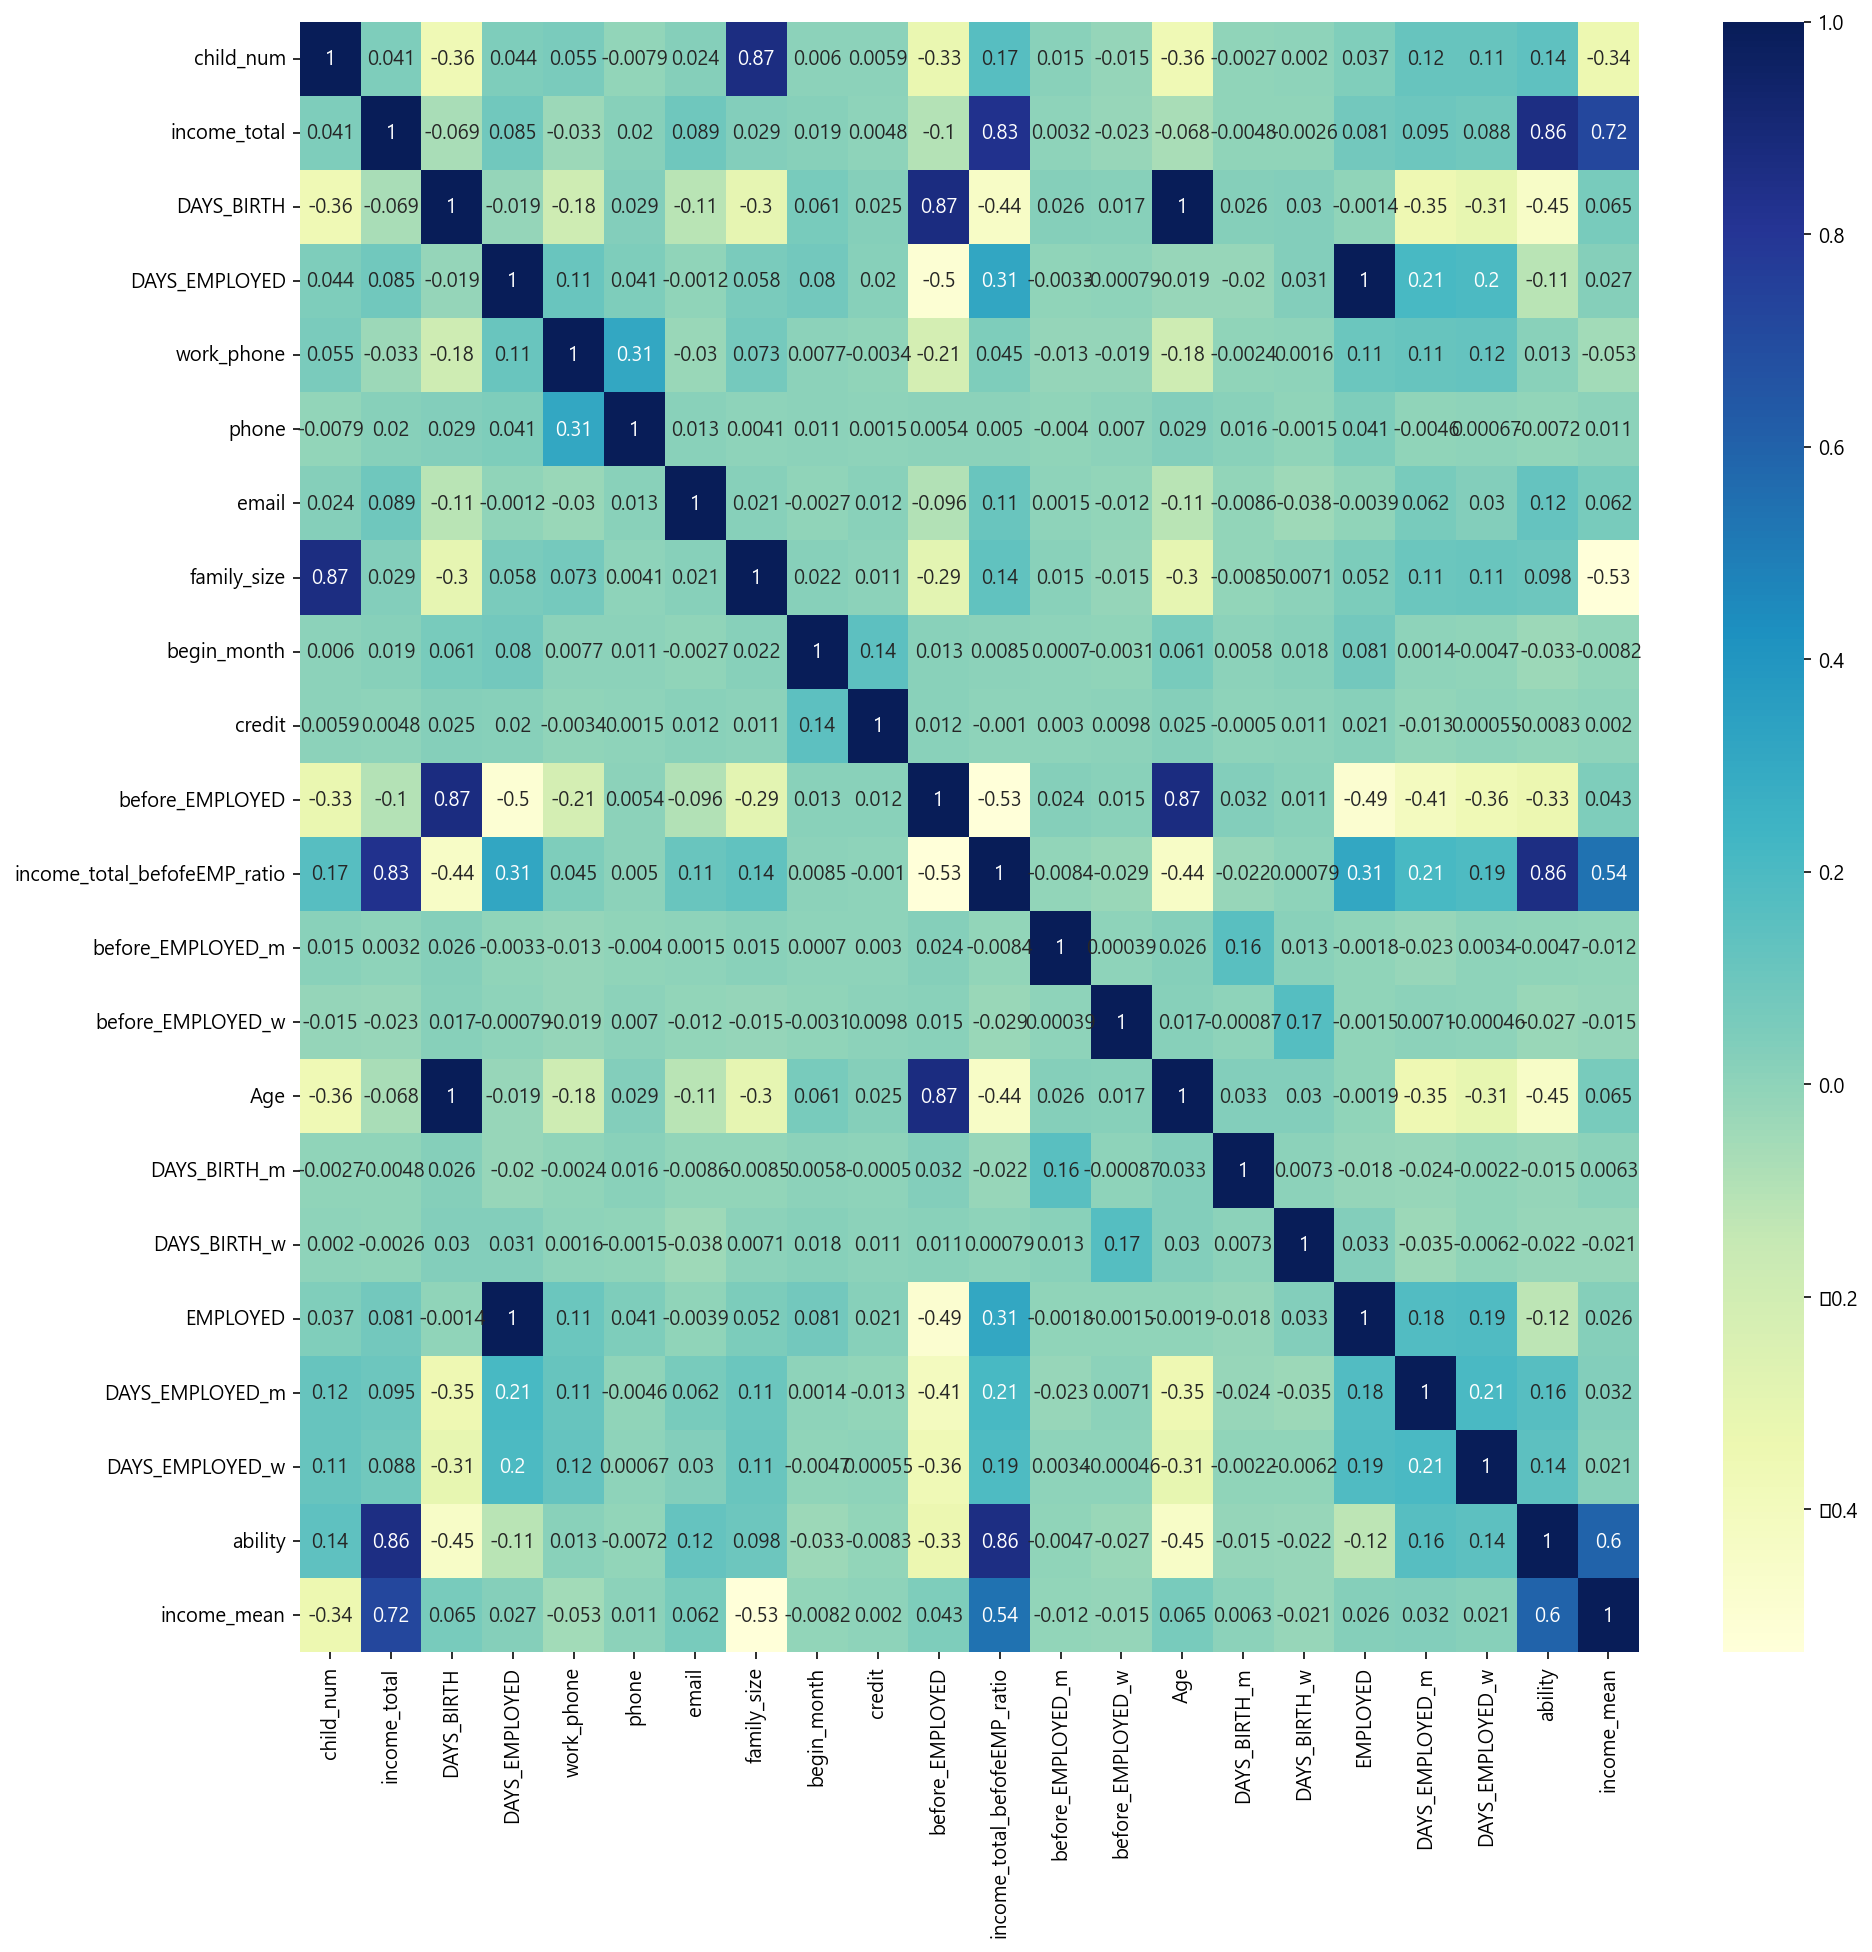

In [13]:
plt.figure(figsize=(15,15))
sns.heatmap(data=train.corr(),annot=True,cmap='YlGnBu')

In [14]:
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

## Scaling, Encoding

In [15]:
numerical_facts = train.dtypes[train.dtypes!='object'].index.tolist()

In [21]:
numerical_facts.remove('credit')
#numerical_facts.remove('Unnamed: 0')

ValueError: list.remove(x): x not in list

In [22]:
print('연속형 feature:', len(numerical_facts),'개')

연속형 feature: 18 개


In [23]:
categorical_facts = train.dtypes[train.dtypes=='object'].index.tolist()

In [24]:
print('범주형 feature:', len(categorical_facts),'개')

범주형 feature: 9 개


In [26]:
categorical_facts

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID']

#### Log scaling

In [27]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

#### OrdinalEncoder

In [28]:
encoder = OrdinalEncoder(categorical_facts)
train[categorical_facts]=encoder.fit_transform(train[categorical_facts],train['credit'])
test[categorical_facts]=encoder.transform(test[categorical_facts])

train['ID']=train['ID'].astype('int64')
test['ID']=test['ID'].astype('int64')

<AxesSubplot:>

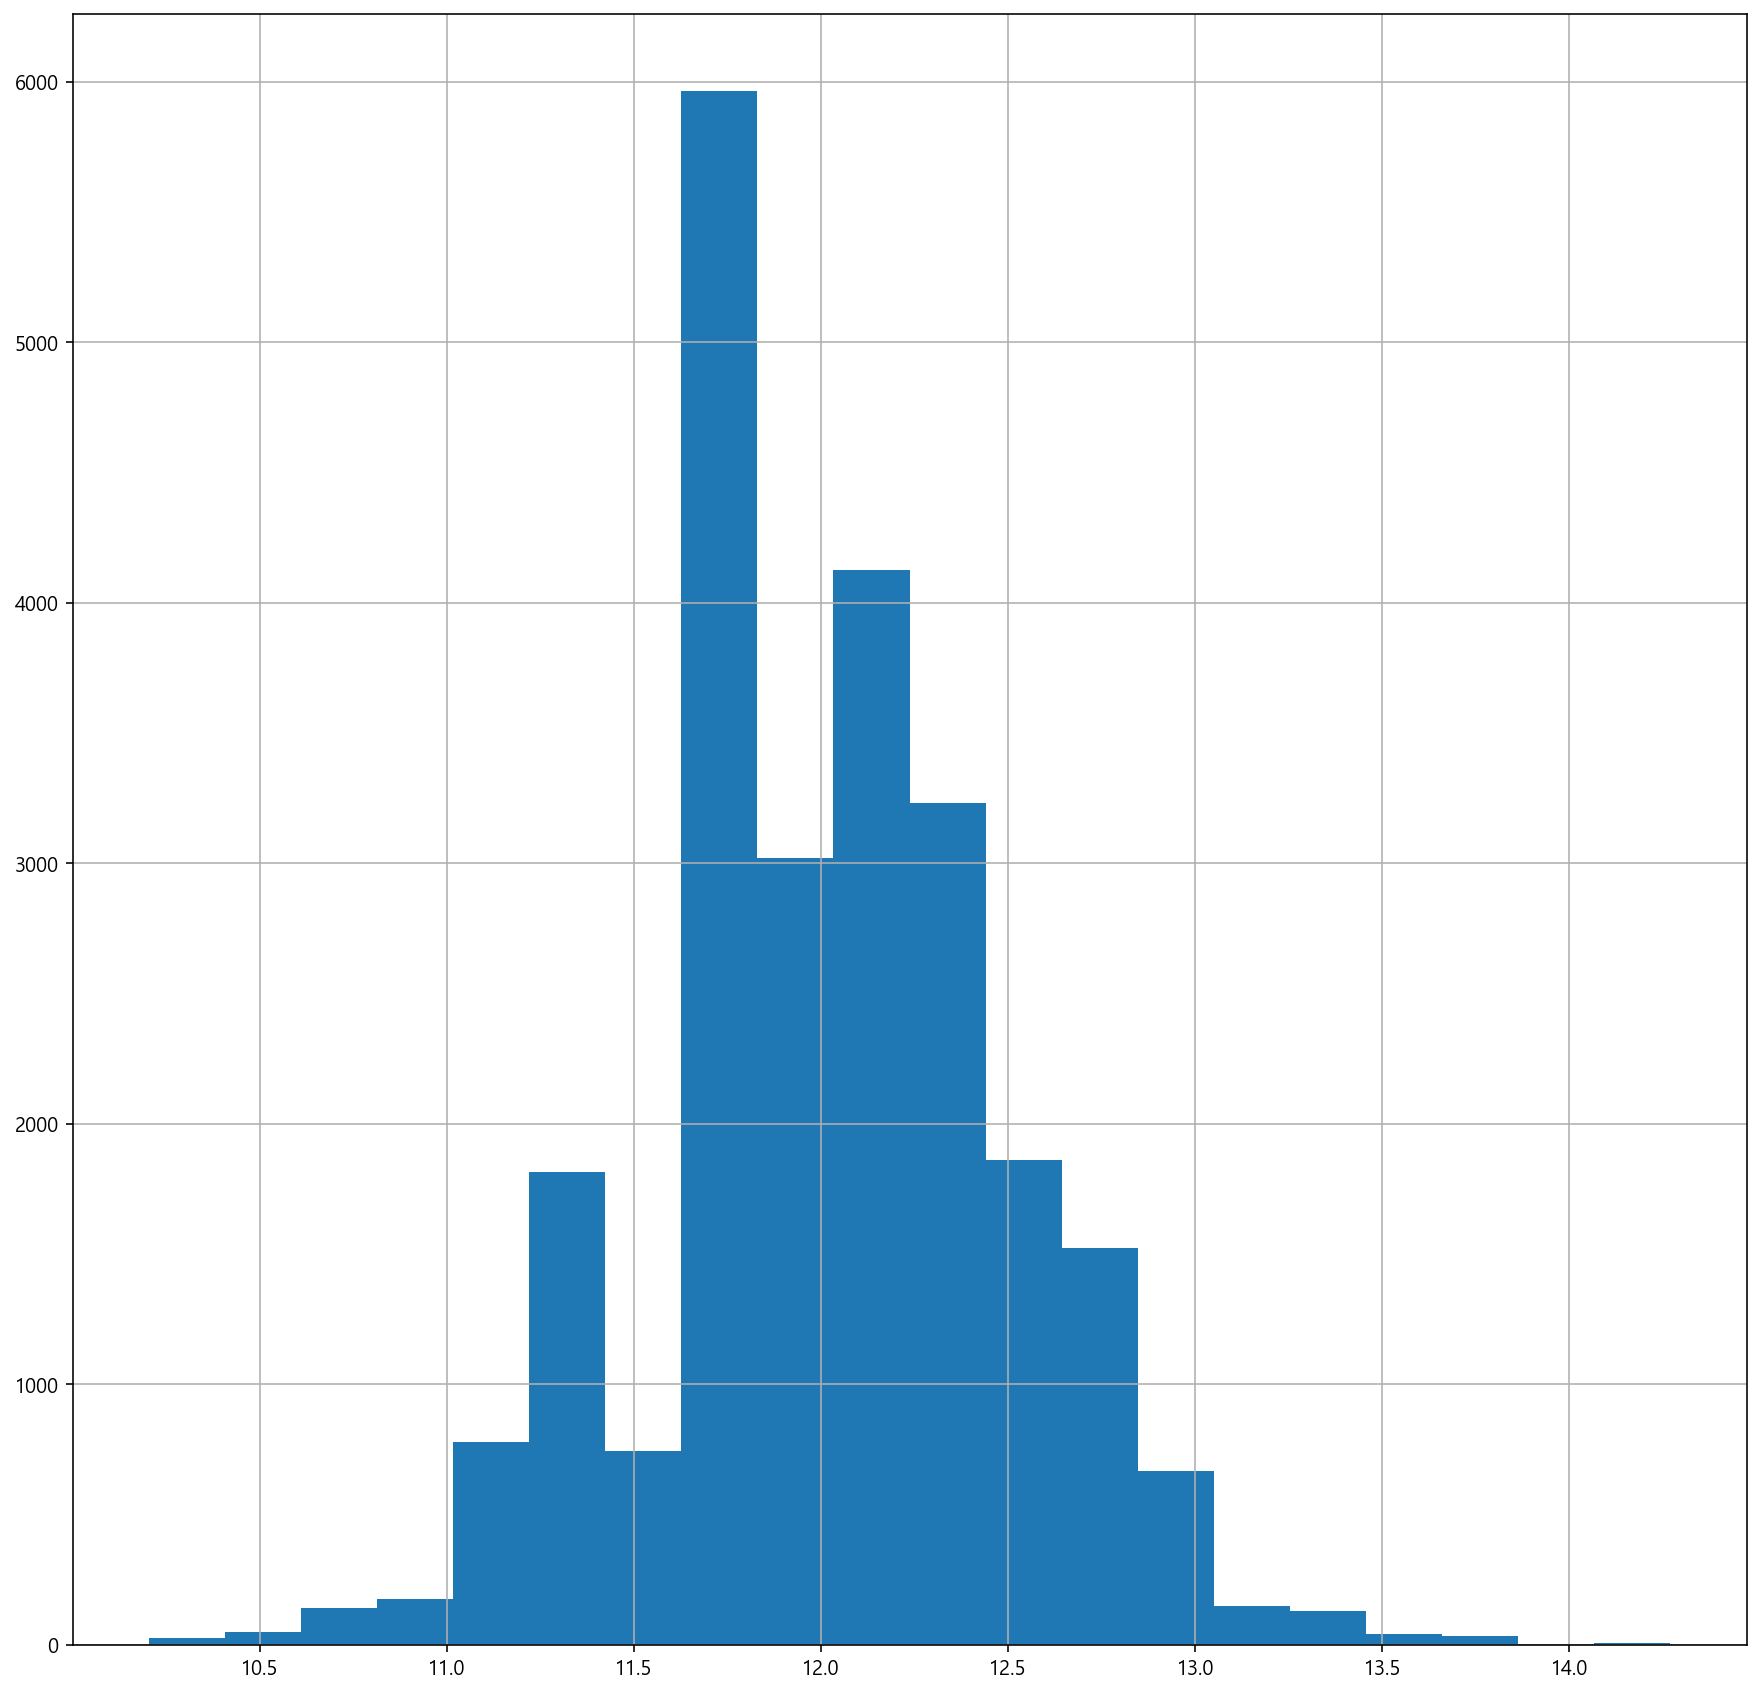

In [29]:
train.income_total.hist(figsize=(15,15),bins=20)

#### Clustering

In [30]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

#### StandardScaler

In [31]:
numerical_facts.remove('income_total')
ss =StandardScaler()
train[numerical_facts]=ss.fit_transform(train[numerical_facts])
test[numerical_facts]=ss.transform(test[numerical_facts])

## Modeling - Catboost

In [32]:
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------

Learning rate set to 0.114948
0:	learn: 1.0366509	test: 1.0371480	best: 1.0371480 (0)	total: 201ms	remaining: 3m 20s
100:	learn: 0.7226531	test: 0.7044046	best: 0.7041297 (86)	total: 4.8s	remaining: 42.8s
200:	learn: 0.7006868	test: 0.7040705	best: 0.7030357 (168)	total: 9.88s	remaining: 39.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7030357451
bestIteration = 168

Shrink model to first 169 iterations.
CV Log Loss Score: 0.703036

----------------- Fold 1 -----------------

Learning rate set to 0.114948
0:	learn: 1.0369689	test: 1.0348832	best: 1.0348832 (0)	total: 76.7ms	remaining: 1m 16s
100:	learn: 0.7219575	test: 0.6835788	best: 0.6835788 (100)	total: 5.05s	remaining: 45s


KeyboardInterrupt: 

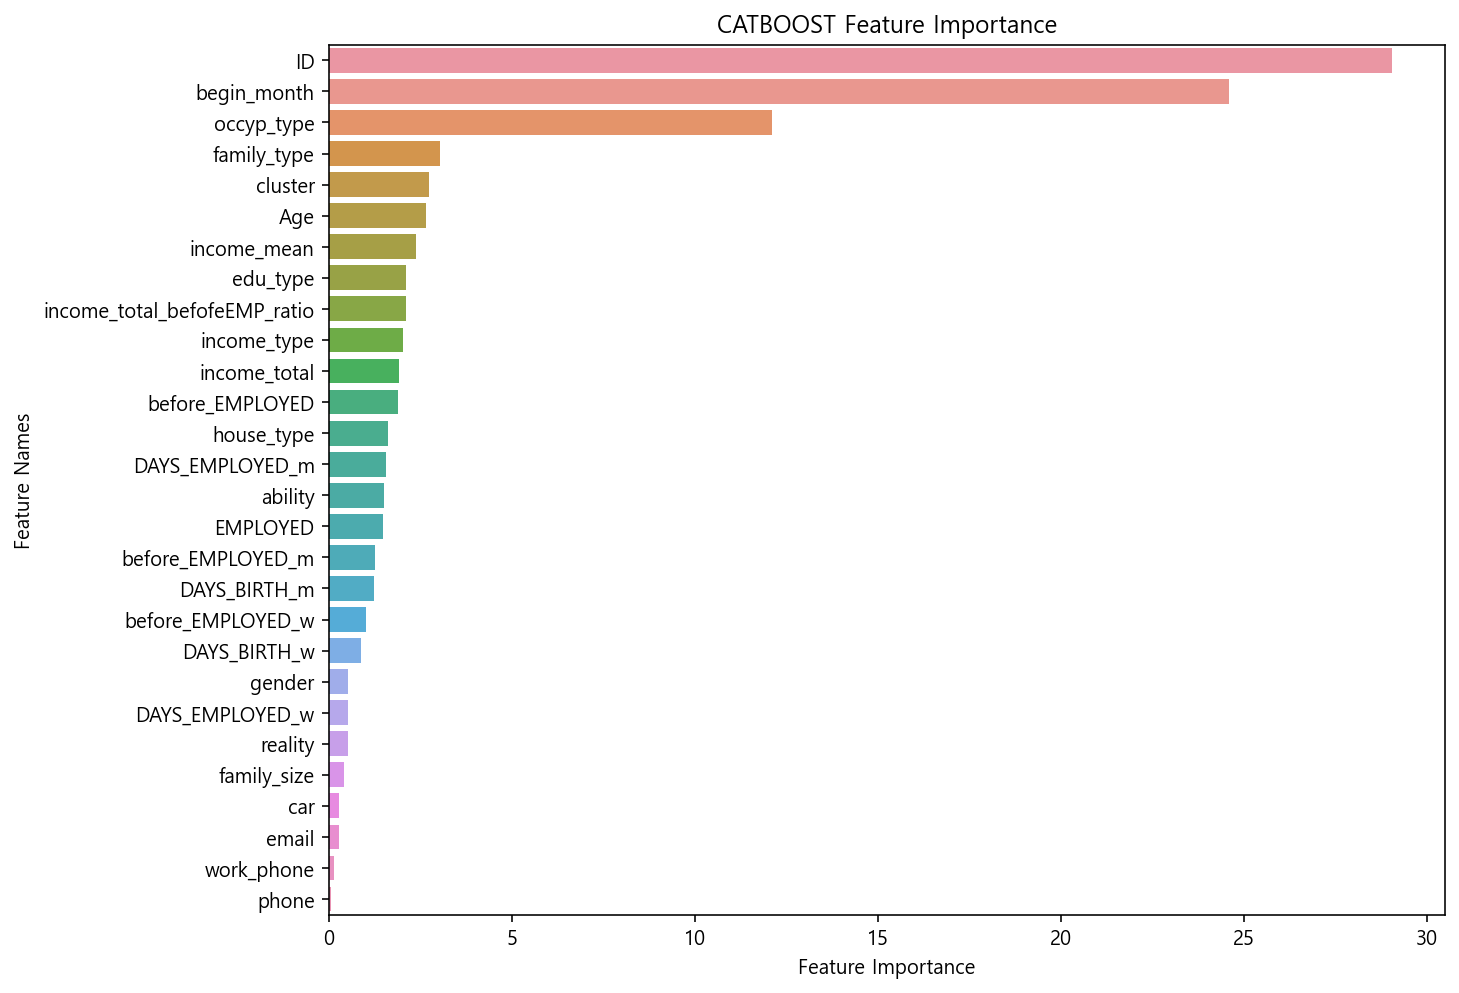

In [49]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')